In [64]:
# Importing necessary libraries
!pip install langid
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import Tokenizer, StopWordsRemover, Word2Vec, PCA
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col, lower, regexp_replace, split, udf
from pyspark.sql.types import StringType, IntegerType 
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
import numpy as np
import langid
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from pyspark.ml.linalg import DenseVector, SparseVector
from pyspark.sql.functions import col, udf

In [65]:
# Create Spark session
spark = SparkSession.builder \
    .config("spark.sql.shuffle.partitions", 10) \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.driver.maxResultSize", "8g") \
    .master("local[*]") \
    .appName("Project 3") \
    .getOrCreate()

# Read data
df = spark.read.json("./dblp-ref/*.json", multiLine=True)

In [66]:
# Show the schema
df.printSchema()
df.show(5)
print(f"Number of records: {df.count()}")

root
 |-- abstract: string (nullable = true)
 |-- authors: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: string (nullable = true)
 |-- n_citation: long (nullable = true)
 |-- references: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title: string (nullable = true)
 |-- venue: string (nullable = true)
 |-- year: long (nullable = true)

+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+
|            abstract|             authors|                  id|n_citation|          references|               title|               venue|year|
+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+
|Based on biologic...|[Guoping Pang, La...|4aa69add-3978-480...|         8|[04754a28-6bf4-4d...|Dynamic analysis ...|Mathematics and C...|2008|
|In this paper, a ...

In [67]:
# Display summary statistics
df.describe().show()

# Check for missing values (excluding `isnan`)
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Distribution of citations
df.select("n_citation").describe().show()

# Check for null abstracts and titles
df.filter(df.abstract.isNull() | df.title.isNull()).show()

+-------+--------------------+--------------------+-----------------+--------------------+--------------------+------------------+
|summary|            abstract|                  id|       n_citation|               title|               venue|              year|
+-------+--------------------+--------------------+-----------------+--------------------+--------------------+------------------+
|  count|                   4|                   4|                4|                   4|                   4|                 4|
|   mean|                NULL|                NULL|             14.5|                NULL|                NULL|           2011.25|
| stddev|                NULL|                NULL|23.96525262402492|                NULL|                NULL|3.9475730941089733|
|    min|AdaBoost algorith...|00127ee2-cb05-48c...|                0|A Heterogeneous S...|Mathematics and C...|              2008|
|    max|The purpose of th...|4ab3735c-80f1-472...|               50|Preliminary De

In [68]:
# Filter only English documents
# Function to detect language using langid
def detect_language(text):
    if text is None:
        return None
    lang, _ = langid.classify(text)
    return lang

# Registering UDF
lang_detect_udf = udf(detect_language, StringType())

# Add a new column for language detection
df = df.withColumn("language", lang_detect_udf(df.abstract))

# Filter only English documents
df = df.filter(df.language == 'en')
df.show()

+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+--------+
|            abstract|             authors|                  id|n_citation|          references|               title|               venue|year|language|
+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+--------+
|Based on biologic...|[Guoping Pang, La...|4aa69add-3978-480...|         8|[04754a28-6bf4-4d...|Dynamic analysis ...|Mathematics and C...|2008|      en|
|In this paper, a ...|[S. Ben Jabra, Ez...|4ab3735c-80f1-472...|        50|[09cb2d7d-47d1-4a...|A new approach of...|international sym...|2008|      en|
|The purpose of th...|[Makoto Satoh, Ry...|00127ee2-cb05-48c...|         0|[51c7e02e-f5ed-43...|Preliminary Desig...|international con...|2013|      en|
|AdaBoost algorith...|[Zheng Xu, Runbin...|001eef4f-1d00-4ae...|         0|[0a1198

In [69]:
# Lowercase and remove punctuation
df_cleaned = df.withColumn("cleaned_abstract", lower(col("abstract")))
df_cleaned = df_cleaned.withColumn("cleaned_abstract", regexp_replace(col("cleaned_abstract"), r'[!()\-\[\]{};:\'",<>./?@#$%^&*_~]', ''))

In [70]:
# Tokenize the text
tokenizer = Tokenizer(inputCol="cleaned_abstract", outputCol="words")
df_tokenized = tokenizer.transform(df_cleaned)

In [71]:
# Remove stop words
custom_stop_words = ['doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI', 'www']
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=StopWordsRemover().getStopWords() + custom_stop_words)
df_filtered = remover.transform(df_tokenized)

In [72]:
# Train a Word2Vec model
word2vec = Word2Vec(vectorSize=100, minCount=1, inputCol="filtered_words", outputCol="word2vec_features")
model = word2vec.fit(df_filtered)
df_vectorized = model.transform(df_filtered)

In [73]:
# Select only the columns we need
df_vectorized = df_vectorized.select("id", "title", "word2vec_features")

In [80]:
# Define UDF for converting sparse to dense vectors
def to_dense(v):
    if isinstance(v, SparseVector):
        return DenseVector(v.toArray())
    elif isinstance(v, DenseVector):
        return v
    else:
        raise TypeError("Unsupported vector type")

to_dense_udf = udf(to_dense, VectorUDT())

# Apply UDF to convert features to dense vectors
df_dense = df_vectorized.withColumn('dense_features', to_dense_udf(col('word2vec_features')))

# Select only the columns we need
df_dense = df_dense.select("id", "title", "dense_features")
df_dense.show()


+--------------------+--------------------+--------------------+
|                  id|               title|      dense_features|
+--------------------+--------------------+--------------------+
|4aa69add-3978-480...|Dynamic analysis ...|[1.08869341519576...|
|4ab3735c-80f1-472...|A new approach of...|[-6.2413792322028...|
|00127ee2-cb05-48c...|Preliminary Desig...|[1.00369512487353...|
|001eef4f-1d00-4ae...|A Heterogeneous S...|[3.46525890993441...|
+--------------------+--------------------+--------------------+



In [81]:
# Sample the data
def sample_data(df, fraction, max_attempts=5):
    attempt = 0
    sampled_df = df.sample(fraction=fraction, seed=42)
    while sampled_df.count() == 0 and attempt < max_attempts:
        fraction *= 2  # Increase fraction to get more data
        sampled_df = df.sample(fraction=fraction, seed=42)
        attempt += 1
    if sampled_df.count() == 0:
        raise ValueError("Sampled DataFrame is empty after several attempts.")
    return sampled_df

df_sampled = sample_data(df_vectorized, 0.1)
print(f"Sampled DataFrame count: {df_sampled.count()}")
df_sampled.show(5)

Sampled DataFrame count: 3
+--------------------+--------------------+--------------------+
|                  id|               title|   word2vec_features|
+--------------------+--------------------+--------------------+
|4aa69add-3978-480...|Dynamic analysis ...|[1.08869341519576...|
|00127ee2-cb05-48c...|Preliminary Desig...|[1.00369512487353...|
|001eef4f-1d00-4ae...|A Heterogeneous S...|[3.46525890993441...|
+--------------------+--------------------+--------------------+



In [82]:
# # Use PCA to reduce dimensions
# pca = PCA(k=2, inputCol="word2vec_features", outputCol="pca_features")
# # df_sampled_repartitioned = df_sampled.repartition(100)
# # df_sampled_repartitioned.persist()
# pca_model = pca.fit(pca)
# df_pca = pca_model.transform(df_sampled_repartitioned)
# df_pca.show()

pca = PCA(k=2, inputCol="word2vec_features", outputCol="pca_features")
pca_model = pca.fit(df_sampled)
df_pca = pca_model.transform(df_sampled)
df_pca.show()

+--------------------+--------------------+--------------------+--------------------+
|                  id|               title|   word2vec_features|        pca_features|
+--------------------+--------------------+--------------------+--------------------+
|4aa69add-3978-480...|Dynamic analysis ...|[1.08869341519576...|[-9.8844176207190...|
|00127ee2-cb05-48c...|Preliminary Desig...|[1.00369512487353...|[0.00517865000732...|
|001eef4f-1d00-4ae...|A Heterogeneous S...|[3.46525890993441...|[-6.0370982168688...|
+--------------------+--------------------+--------------------+--------------------+



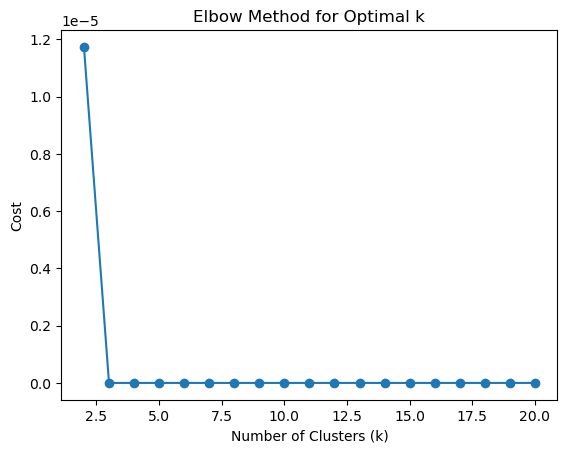

In [77]:
# Elbow Method to Find Optimal K
costs = []
for k in range(2, 21):
    kmeans = KMeans(k=k, seed=1, featuresCol="pca_features")
    model = kmeans.fit(df_pca)
    costs.append(model.summary.trainingCost)

plt.plot(range(2, 21), costs, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()

In [78]:
# KMeans Clustering (using the optimal k from the elbow method)
optimal_k = 10  # Set this to the optimal value from the elbow method
kmeans = KMeans(k=optimal_k, seed=1, featuresCol="pca_features")
model = kmeans.fit(df_pca)
df_clustered = model.transform(df_pca)
# df_clustered.show()

In [79]:
# Basic search engine function
def recommend_papers(title, top_n=5):
    paper_cluster = df_clustered.filter(df_clustered.title == title).select("prediction").collect()[0][0]
    cluster_papers = df_clustered.filter(df_clustered.prediction == paper_cluster)
    paper_features = np.array(cluster_papers.filter(cluster_papers.title == title).select("pca_features").collect()[0][0])
    similarities = []

    for row in cluster_papers.collect():
        other_title = row["title"]
        other_features = np.array(row["pca_features"])
        similarity = cosine_similarity([paper_features], [other_features])[0][0]
        similarities.append((other_title, similarity))

    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# Example usage
recommended_papers = recommend_papers("example_paper_title", top_n=2)
print(recommended_papers)

IndexError: list index out of range

In [ ]:
# Importing necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import Tokenizer, StopWordsRemover, Word2Vec, PCA
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col, lower, regexp_replace, udf
from pyspark.sql.types import StringType
from pyspark.ml.linalg import SparseVector, DenseVector, VectorUDT
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Create Spark session
spark = SparkSession.builder \
    .config("spark.sql.shuffle.partitions", 10) \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.driver.maxResultSize", "8g") \
    .master("local[*]") \
    .appName("Project 3") \
    .getOrCreate()

# Read data
df = spark.read.json("./dblp-ref/*.json", multiLine=True)

# Show the schema
df.printSchema()
df.show(5)
print(f"Number of records: {df.count()}")

# Check for missing values
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Filter only English documents
# df = df.filter(df.language == 'en')

# Lowercase and remove punctuation
df_cleaned = df.withColumn("cleaned_abstract", lower(col("abstract")))
df_cleaned = df_cleaned.withColumn("cleaned_abstract", regexp_replace(col("cleaned_abstract"), r'[!()\-\[\]{};:\'",<>./?@#$%^&*_~]', ''))

# Tokenize the text
tokenizer = Tokenizer(inputCol="cleaned_abstract", outputCol="words")
df_tokenized = tokenizer.transform(df_cleaned)

# Remove stop words
custom_stop_words = ['doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI', 'www']
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=StopWordsRemover().getStopWords() + custom_stop_words)
df_filtered = remover.transform(df_tokenized)

# Train a Word2Vec model
word2vec = Word2Vec(vectorSize=100, minCount=1, inputCol="filtered_words", outputCol="word2vec_features")
model = word2vec.fit(df_filtered)
df_vectorized = model.transform(df_filtered)

# Define UDF for converting sparse to dense vectors
def to_dense(v):
    if isinstance(v, SparseVector):
        return DenseVector(v.toArray())
    elif isinstance(v, DenseVector):
        return v
    else:
        raise TypeError("Unsupported vector type")

to_dense_udf = udf(to_dense, VectorUDT())

# Apply UDF to convert features to dense vectors
df_dense = df_vectorized.withColumn('dense_features', to_dense_udf(col('word2vec_features')))

# Select only the columns we need
df_dense = df_dense.select("id", "title", "dense_features")

# Sample the data
def sample_data(df, fraction, max_attempts=5):
    attempt = 0
    sampled_df = df.sample(fraction=fraction, seed=42)
    while sampled_df.count() == 0 and attempt < max_attempts:
        fraction *= 2  # Increase fraction to get more data
        sampled_df = df.sample(fraction=fraction, seed=42)
        attempt += 1
    if sampled_df.count() == 0:
        raise ValueError("Sampled DataFrame is empty after several attempts.")
    return sampled_df

df_sampled = sample_data(df_dense, 0.1)
print(f"Sampled DataFrame count: {df_sampled.count()}")
df_sampled.show(5)

# Use PCA to reduce dimensions
pca = PCA(k=2, inputCol="dense_features", outputCol="pca_features")
df_sampled_repartitioned = df_sampled.repartition(100)
df_sampled_repartitioned.persist()
pca_model = pca.fit(df_sampled_repartitioned)
df_pca = pca_model.transform(df_sampled_repartitioned)
df_pca.show()

# Elbow Method to Find Optimal K
costs = []
for k in range(2, 21):
    kmeans = KMeans(k=k, seed=1, featuresCol="pca_features")
    model = kmeans.fit(df_pca)
    costs.append(model.summary.trainingCost)

plt.plot(range(2, 21), costs, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()

# KMeans Clustering (using the optimal k from the elbow method)
optimal_k = 10  # Set this to the optimal value from the elbow method
kmeans = KMeans(k=optimal_k, seed=1, featuresCol="pca_features")
model = kmeans.fit(df_pca)
df_clustered = model.transform(df_pca)

# Basic search engine function
def recommend_papers(title, top_n=5):
    paper_cluster = df_clustered.filter(df_clustered.title == title).select("prediction").collect()[0][0]
    cluster_papers = df_clustered.filter(df_clustered.prediction == paper_cluster)
    paper_features = np.array(cluster_papers.filter(cluster_papers.title == title).select("pca_features").collect()[0][0])
    similarities = []

    for row in cluster_papers.collect():
        other_title = row["title"]
        other_features = np.array(row["pca_features"])
        similarity = cosine_similarity([paper_features], [other_features])[0][0]
        similarities.append((other_title, similarity))

    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# Example usage
recommended_papers = recommend_papers("example_paper_title", top_n=5)
print(recommended_papers)
